# Q2: Lets go deeper! CaffeNet for PASCAL classification (20 pts)

**Note:** You are encouraged to reuse code from the previous task. Finish Q1 if you haven't already!


As you might have seen, the performance of the SimpleCNN model was pretty low for PASCAL. This is expected as PASCAL is much more complex than FASHION MNIST, and we need a much beefier model to handle it.

In this task we will be constructing a variant of the [AlexNet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf) architecture, known as CaffeNet. If you are familiar with Caffe, a prototxt of the network is available [here](https://github.com/BVLC/caffe/blob/master/models/bvlc_reference_caffenet/train_val.prototxt). A visualization of the network is available [here](http://ethereon.github.io/netscope/#/preset/caffenet).


## 2.1 Build CaffeNet (5 pts)
Here is the exact model we want to build. In this task, `torchvision.models.xxx()` is NOT allowed. Define your own CaffeNet! We use the following operator notation for the architecture:
1. Convolution: A convolution with kernel size $k$, stride $s$, output channels $n$, padding $p$ is represented as $conv(k, s, n, p)$.
2. Max Pooling: A max pool operation with kernel size $k$, stride $s$ as $maxpool(k, s)$.
3. Fully connected: For $n$ output units, $FC(n)$.
4. ReLU: For rectified linear non-linearity $relu()$

```
ARCHITECTURE:
-> image
-> conv(11, 4, 96, ’VALID’)
-> relu()
-> max_pool(3, 2)
-> conv(5, 1, 256, 'SAME')
-> relu()
-> max_pool(3, 2)
-> conv(3, 1, 384, 'SAME')
-> relu()
-> conv(3, 1, 384, 'SAME')
-> relu()
-> conv(3, 1, 256, ’SAME’)
-> relu()
-> max_pool(3, 2)
-> flatten()
-> fully_connected(4096)
-> relu()
-> dropout(0.5)
-> fully_connected(4096)
-> relu()
-> dropout(0.5)
-> fully_connected(20)
```

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

import trainer
from utils import ARGS
from simple_cnn import SimpleCNN
from voc_dataset import VOCDataset


class CaffeNet(nn.Module):
    def __init__(self, num_classes=20, inp_size=224, c_dim=3):
        super().__init__()
        self.conv1 = nn.Conv2d(c_dim, 96, 11, stride=4)
        self.conv2 = nn.Conv2d(96, 256, 5, stride=1, padding=(2,2))
        self.conv3 = nn.Conv2d(256, 384, 3, stride=1, padding=(1,1))
        self.conv4 = nn.Conv2d(384, 384, 3, 1, 1)
        self.conv5 = nn.Conv2d(384, 256, 3, 1, 1)
        self.fcn1 = nn.Linear(5*5*256, 4096)
        self.fcn2 = nn.Linear(4096, 4096)
        self.fcn3 = nn.Linear(4096, num_classes)
        self.regular = nn.Dropout(0.5)
        self.activation = nn.ReLU()
        self.pooling = nn.MaxPool2d(3, 2)
    
    def forward(self, x):
        out1 = self.pooling(self.activation(self.conv1(x)))
        out2 = self.pooling(self.activation(self.conv2(out1)))
        out3 = self.activation(self.conv3(out2))
        out4 = self.activation(self.conv4(out3))
        out5 = self.pooling(self.activation(self.conv5(out4)))
        out5 = out5.reshape(out5.shape[0], -1)
        out6 = self.regular(self.activation(self.fcn1(out5)))
        out7 = self.regular(self.activation(self.fcn2(out6)))
        out8 = self.fcn3(out7)
        return out8

    #this is for q5 to return pool5
    def forward_analysis_pool5(self, x):
        out1 = self.pooling(self.activation(self.conv1(x)))
        out2 = self.pooling(self.activation(self.conv2(out1)))
        out3 = self.activation(self.conv3(out2))
        out4 = self.activation(self.conv4(out3))
        out5 = self.pooling(self.activation(self.conv5(out4)))
        out5 = out5.reshape(out5.shape[0], -1)
        return out5

    #this is for q5 to return fc7
    def forward_analysis_fc7(self, x):
        out1 = self.pooling(self.activation(self.conv1(x)))
        out2 = self.pooling(self.activation(self.conv2(out1)))
        out3 = self.activation(self.conv3(out2))
        out4 = self.activation(self.conv4(out3))
        out5 = self.pooling(self.activation(self.conv5(out4)))
        out5 = out5.reshape(out5.shape[0], -1)
        out6 = self.regular(self.activation(self.fcn1(out5)))
        out7 = self.regular(self.activation(self.fcn2(out6)))
        return out7

## 2.2 Save the Model (5 pts)
Fill out `save_model()` in `trainer.py` to save the checkpoints of the model periodically. **You will need these models later.**


## 2.3 Train and Test (5pts)
Show clear screenshots of testing MAP and training loss for 50 epochs. The final MAP should be at least around 0.4. Please evaluate your model to calculate the MAP on the testing dataset every 250 iterations. Use the following hyperparamters:
* batch_size=32
* Adam optimizer with lr=0.0001

**NOTE: SAVE AT LEAST 5 EVENLY SPACED CHECKPOINTS DURING TRAINING (1 at end)**

In [4]:
args = ARGS(batch_size=32, epochs=50,lr=0.0001, save_at_end=True, \
            save_freq=10, use_cuda=True, val_every=250, step_size=20, gamma=0.2)
model = CaffeNet()
optimizer = torch.optim.Adam(model.parameters(), args.lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, args.step_size, args.gamma)
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, args.gamma)
test_ap, test_map = trainer.train(args, model, optimizer, scheduler, "caffenet")
print('test map:', test_map)

Train Epoch: 0 [0 (0%)]	Loss: 0.680610
Train Epoch: 0 [100 (64%)]	Loss: 0.245385
Train Epoch: 1 [200 (27%)]	Loss: 0.214580
Train Epoch: 1 [300 (91%)]	Loss: 0.195987
Train Epoch: 2 [400 (55%)]	Loss: 0.216594
Train Epoch: 3 [500 (18%)]	Loss: 0.192287
Train Epoch: 3 [600 (82%)]	Loss: 0.215970
Train Epoch: 4 [700 (46%)]	Loss: 0.222798
Train Epoch: 5 [800 (10%)]	Loss: 0.195831
Train Epoch: 5 [900 (73%)]	Loss: 0.181027
Train Epoch: 6 [1000 (37%)]	Loss: 0.191647
Train Epoch: 7 [1100 (1%)]	Loss: 0.202245
Train Epoch: 7 [1200 (64%)]	Loss: 0.174693
Train Epoch: 8 [1300 (28%)]	Loss: 0.217424
Train Epoch: 8 [1400 (92%)]	Loss: 0.172403
Train Epoch: 9 [1500 (55%)]	Loss: 0.192192
Train Epoch: 10 [1600 (19%)]	Loss: 0.204493
Train Epoch: 10 [1700 (83%)]	Loss: 0.161235
Train Epoch: 11 [1800 (46%)]	Loss: 0.163877
Train Epoch: 12 [1900 (10%)]	Loss: 0.126206
Train Epoch: 12 [2000 (74%)]	Loss: 0.163106
Train Epoch: 13 [2100 (38%)]	Loss: 0.172990
Train Epoch: 14 [2200 (1%)]	Loss: 0.125785
Train Epoch: 14 [23

**INSERT YOUR TENSORBOARD SCREENSHOTS HERE**
MAP vs Iteration number


Train loss vs iteration number
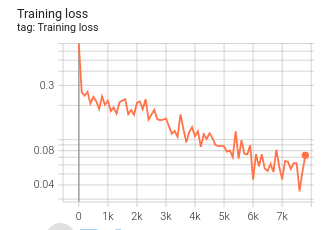

Test MAP vs iteration
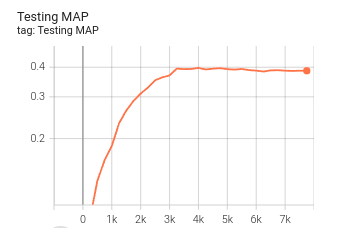

LR VS iteration
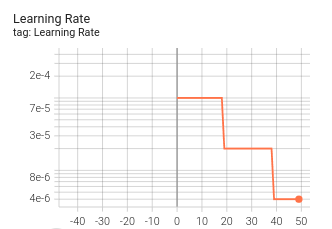

## 2.4 Visualizing: Conv-1 filters (5pts)
Extract and compare the weights of conv1 filters at different stages of the training (at least from 5 different epochs).

- Write a function to load your model checkpoints.
- Get the weights for conv1 from the loaded model.
- Visualize the weights using the following vis() function.

Sometimes the filters all look very random and may not change too much across epochs. Don't worry! You will get full credits as long as the code is correct.

In [5]:
import numpy as np
from PIL import Image

# This function plots all the filters in one image. 
def vis(conv1):
    assert type(conv1) == np.ndarray
    assert conv1.shape == (11, 11, 3, 96)
    im = np.zeros((120, 120, 3))
    step_size = 12
    column = 0
    row = 0
    for k in range(conv1.shape[3]):
        this_filter = conv1[:, :, :, k]
        im[column*step_size:column*step_size+11, row*step_size:row*step_size+11, :] = this_filter
        column = column + 1
        if column == 10:
            column = 0
            row = row + 1
    image = Image.fromarray(np.uint8((im-np.mean(im))/np.std(im)))
    display(image)
    return image

Epoch: 10


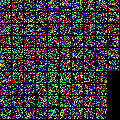

Epoch: 20


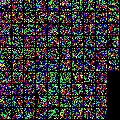

Epoch: 30


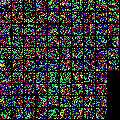

Epoch: 40


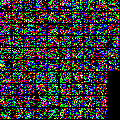

Epoch: 50


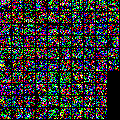

In [6]:
# Write your code here to get the conv1 filters for each epoch
conv1s = [np.random.randn(11, 11, 3, 96)]
model = model.to('cpu')
for epoch in range(10, 51, 10):
    print("Epoch:", epoch)
    filename = 'checkpoint-{}-epoch{}.pth'.format('caffenet', epoch)
    model.load_state_dict(torch.load(filename))
    conv1 = model.conv1.weight
    conv1 = (torch.permute(conv1, (2, 3, 1, 0))).detach().numpy()
    vis(conv1)
# For each epoch, use vis() to visualize the filters.
# Before passing the weights into vis(), make sure it is an numpy array with shape (11, 11, 3, 96).
# You may need torch.permute to reorganize the dimensions.